In [1]:
#Boiler plate imports
import uproot 
import pandas as pd
import sys
import matplotlib.pyplot as plt
import numpy as np
from time import time

#Other imports
import matplotlib.colors as colors
from matplotlib.patches import Circle
from matplotlib.patches import Patch

#SBND imports
sys.path.append('/sbnd/app/users/brindenc/mysbnana_v09_75_03/srcs/sbnana/sbnana/SBNAna/pyana')
from makedf.branches import *
from sbnd.general import utils,plotters
from sbnd.volume import involume
from sbnd.cafclasses.nu import NU
from sbnd.cafclasses.mcprim import MCPRIM
from sbnd.constants import *
from sbnd.prism import *
from pyanalib import panda_helpers

#numu helpers
from sbnd.numu import selection
from sbnd.numu.numu_constants import *

%load_ext autoreload
%autoreload 2

In [2]:
#Constants/variables
PLOTS_DIR = f'Plots/nu_{plotters.day}'
DATA_DIR  = '/sbnd/data/users/brindenc/analyze_sbnd/numu/'
GENIE_MODEL = 'GENIE 3.0.6 G18_10a_02_11a'
GIBUU_MODEL = 'GiBUU 2021'
SIM_LABEL = 'SBND Simulation'

#Normalize to 10e20 POT / 12 -> 3 months
nom_pot = 10e20/12 #3 months

#More constants
GIBUU_LABEL = f'{SIM_LABEL}\n{GIBUU_MODEL}\n{nom_pot:.2e} POT'
GENIE_LABEL = f'{SIM_LABEL}\n{GENIE_MODEL}\n{nom_pot:.2e} POT'

save_plots = False

## Load Preprocessed data (do this if you've already processed the data)

In [3]:
#Get pot first
genie_hdr_df = pd.read_hdf(f'{DATA_DIR}/MCP2022A/MCP2022A_10k.df', key='hdr')
gibuu_hdr_df = pd.read_hdf(f'{DATA_DIR}/gibuu/gibuu_v0.df', key='hdr')

genie_pot = np.sum(genie_hdr_df.pot)
gibuu_pot = np.sum(gibuu_hdr_df.pot)

#Now setup data with attributes
genie_nu = NU(pd.read_hdf(f'{DATA_DIR}/MCP2022A/mcp2022A_processed.h5', key='mcnu')
              ,pot=genie_pot
              ,prism_bins=PRISM_BINS)
genie_prim = MCPRIM(pd.read_hdf(f'{DATA_DIR}/MCP2022A/mcp2022A_processed.h5', key='mcprim')
                      ,pot=genie_pot
                      ,prism_bins=PRISM_BINS
                      ,momentum_bins=MOMENTUM_BINS
                      ,costheta_bins=COSTHETA_BINS)


gibuu_nu = NU(pd.read_hdf(f'{DATA_DIR}/gibuu/gibuu_v0_processed.h5', key='mcnu')
              ,pot=gibuu_pot
              ,prism_bins=PRISM_BINS)
gibuu_prim = MCPRIM(pd.read_hdf(f'{DATA_DIR}/gibuu/gibuu_v0_processed.h5', key='mcprim')
                    ,pot=gibuu_pot
                    ,prism_bins=PRISM_BINS
                    ,momentum_bins=MOMENTUM_BINS
                    ,costheta_bins=COSTHETA_BINS)

#Replace all gibuu modes with 2 (all resonant)
gibuu_nu.data.genie_mode = gibuu_nu.data.genie_mode.where((gibuu_nu.data.genie_mode < 3)\
  | (gibuu_nu.data.genie_mode >= 32),2)

#Scale genweight to POT
genie_nu.scale_to_pot(nom_pot)
gibuu_nu.scale_to_pot(nom_pot)

--scaling to POT: 8.85e+19 -> 8.33e+19
--scaling to POT: 8.17e+19 -> 8.33e+19


## PRISM Plots

In [38]:
def make_prism_rings(theta,ax,**pltkwargs):
  center = prism_centroid
  radius = calc_rf(theta)
  [ax.add_patch(Circle(center,radius=r1,**pltkwargs)) for r1 in radius]
  return ax
def make_prism_plot(nu_df,**pltkwargs):
  fig,ax = plt.subplots(figsize=(10,8))
  im = ax.hist2d(nu_df.position.x,nu_df.position.y,**pltkwargs)#,norm=colors.LogNorm())
  cbar = fig.colorbar(im[3],ax=ax)
  cbar.ax.tick_params(labelsize=16)
  
  #prism lines
  ax.scatter(-74,0,s=200,c='red',marker='x')
  ax = make_prism_rings(PRISM_BINS,ax,fill=False,ls='--',lw=2,color='red',alpha=0.4)
  
  
  ax.set_xlabel('x [cm]')
  ax.set_ylabel('y [cm]')
  ax.set_title(rf'{round(np.sum(nu_df.genweight.values)):,} $\nu_\mu CC$ events')
  return fig,ax

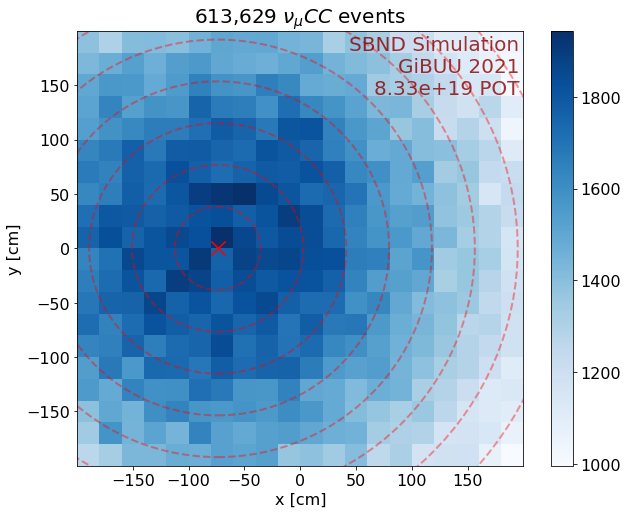

In [39]:
#Gibuu
fig,ax = make_prism_plot(gibuu_nu.data,bins=20,cmap='Blues',weights=gibuu_nu.data.genweight)

plotters.add_label(ax,GIBUU_LABEL,fontsize=20,alpha=0.8,color='darkred')
plotters.set_style(ax)
if save_plots:
  plotters.save_plot('gibuu_prism',fig=fig,folder_name=PLOTS_DIR)

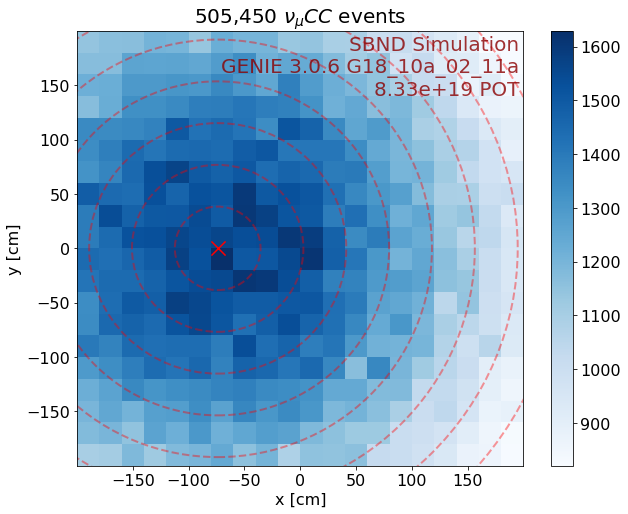

In [40]:
#Genie
fig,ax = make_prism_plot(genie_nu.data,bins=20,cmap='Blues',weights=genie_nu.data.genweight)

plotters.add_label(ax,GENIE_LABEL,fontsize=20,alpha=0.8,color='darkred')
plotters.set_style(ax)
if save_plots:
  plotters.save_plot('genie_prism',fig=fig,folder_name=PLOTS_DIR)

## Interaction Breakdown

In [41]:
def make_mode_plots(nu_df,mode_map,weights=None,ylabel='Events',bins=np.arange(0,5.1,0.1),density=False,title=None,
                    ax=None,fig=None,**pltkwargs):
  norm = len(nu_df)/np.sum(nu_df.genweight.values)
  modes = np.unique(nu_df.genie_mode.values)
  Es = [None]*len(modes)
  counts = Es.copy()
  labels = Es.copy()
  if weights is not None:
    weight_modes = Es.copy()
  for i,mode in enumerate(modes):
    Es[i] = list(nu_df[nu_df.genie_mode==mode].E) #Get energy from mode
    labels[i] = f'{mode_map[mode]} : {round(len(Es[i])/norm):,}' #Mode label and 
    if weights is not None:
      weight_modes[i] = nu_df[nu_df.genie_mode==mode].genweight
  if fig is None and ax is None: #Make figure if not provided
    fig,ax = plt.subplots(figsize=(10,8))
  if not density:
    if weights is None:
      ax.hist(Es,stacked=True,label=labels,bins=bins,**pltkwargs)
    else:
      ax.hist(Es,stacked=True,label=labels,weights=weight_modes,bins=bins,**pltkwargs)
  if density:
    # Calculate total counts in each bin across all modes first
    if weights is None:
      total_counts, edges = np.histogram(np.concatenate(Es), bins=bins)
    else:
      total_counts, edges = np.histogram(np.concatenate(Es), bins=bins, weights=np.concatenate(weight_modes))
    bottom = np.zeros(len(total_counts))
    actual_counts = bottom.copy()
    for i,_ in enumerate(modes):
      if weights is None:
        counts, edges = np.histogram(Es[i], bins=bins)
      else:
        counts, edges = np.histogram(Es[i], weights=weight_modes[i], bins=bins)
      actual_counts += counts
      fractions = counts / total_counts
      ax.bar(edges[:-1], height=fractions, bottom=bottom, align='edge', width=np.diff(edges), label=labels[i],fill=True, **pltkwargs)
      # Add the fraction as text in the middle of the bar
      # bar_centers = edges[:-1] + np.diff(edges) / 2  # Calculate the center of each bar
      # for i,(center, fraction) in enumerate(zip(bar_centers, fractions)):
      #   if np.isnan(fraction): continue
      #   ax.text(center, bottom[i] + fraction / 2, f'{fraction*100:.1f}%', ha='center', va='center',rotation=90)
      bottom += fractions  # Update the bottom for the next mode
      bottom = [b if not np.isnan(b) else 0 for b in bottom]
    ax.grid(True)
  if title is None:
    title = rf'{round(len(nu_df)/norm):,} $\nu_\mu CC$ events'
  ax.set_title(title)
  ax.set_xlabel(r'$E_\nu$ [GeV]')
  if ylabel is not None:
    ax.set_ylabel(f'{ylabel} / {round((bins[1]-bins[0])*1e3):,} MeV')
  return fig,ax

/tmp/ipykernel_28714/1061443038.py:36: RuntimeWarning: invalid value encountered in true_divide
  fractions = counts / total_counts


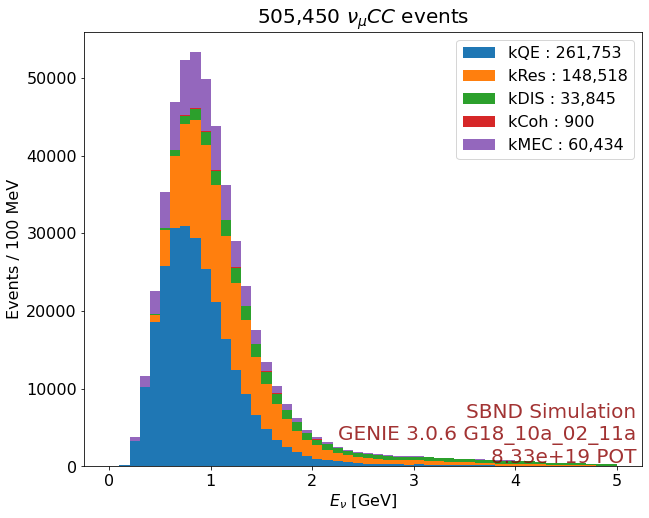

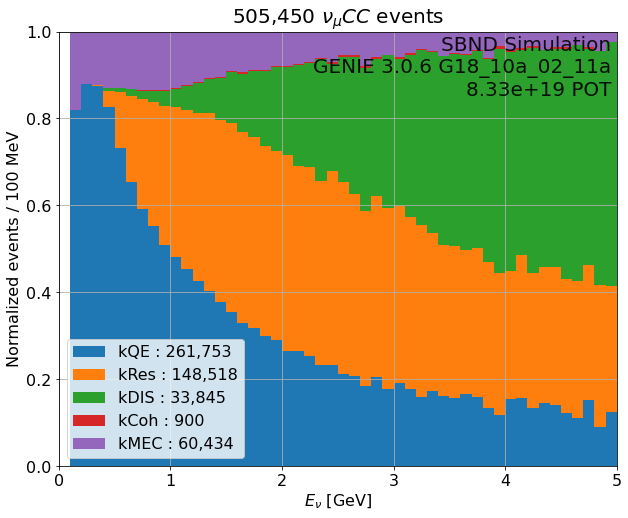

In [42]:
#GENIE
for i,dens in enumerate(['','_dens']):
  fig,ax = make_mode_plots(genie_nu.data,GENIE_INTERACTION_MAP,weights=genie_nu.data.genweight,
                          density=True if i == 1 else False, #set density
                          ylabel='Normalized events' if i == 1 else 'Events',
                          )
  ax.legend()
  plotters.set_style(ax)
  if i == 0:
    plotters.add_label(ax,GENIE_LABEL,where='bottomright',fontsize=20,alpha=0.8,color='darkred')
  elif i == 1:
    plotters.add_label(ax,GENIE_LABEL,where='topright',fontsize=20,alpha=0.9,color='black')
    ax.set_ylim([0,1])
    ax.set_xlim([0,5])
  if save_plots:
    plotters.save_plot(f'genie_modes{dens}',fig=fig,folder_name=PLOTS_DIR)

/tmp/ipykernel_28714/1061443038.py:36: RuntimeWarning: invalid value encountered in true_divide
  fractions = counts / total_counts


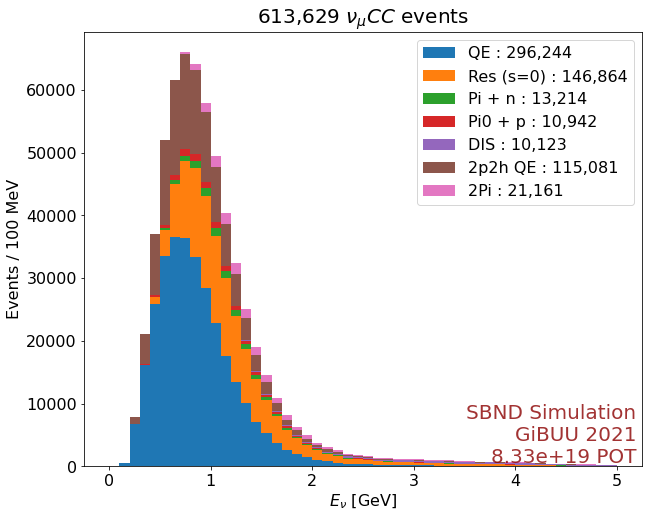

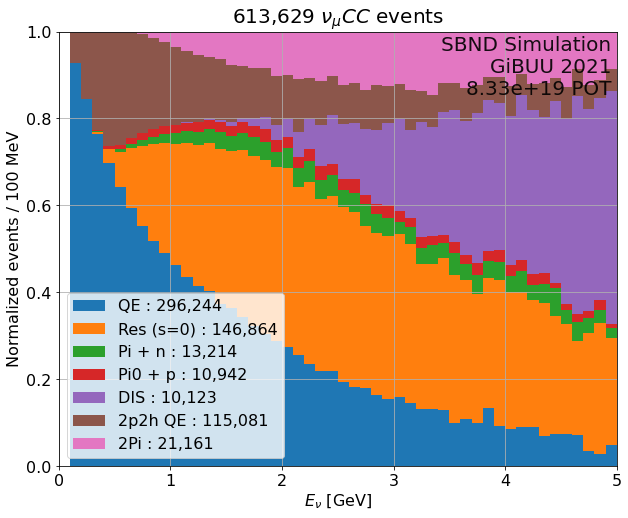

In [43]:
#GIBUU
for i,dens in enumerate(['','_dens']):
  fig,ax = make_mode_plots(gibuu_nu.data,GIBUU_INTERACTION_MAP,weights=gibuu_nu.data.genweight,
                          density=True if i == 1 else False, #set density
                          ylabel='Normalized events' if i == 1 else 'Events',
                          )
  ax.legend()
  plotters.set_style(ax)
  if i == 0:
    plotters.add_label(ax,GIBUU_LABEL,where='bottomright',fontsize=20,alpha=0.8,color='darkred')
  elif i == 1:
    plotters.add_label(ax,GIBUU_LABEL,where='topright',fontsize=20,alpha=0.9,color='black')
    ax.set_ylim([0,1])
    ax.set_xlim([0,5])
  if save_plots:
    plotters.save_plot(f'gibuu_modes{dens}',fig=fig,folder_name=PLOTS_DIR)

In [51]:
#Assign prism bins
#genie_nu.assign_prism_bins()
#gibuu_nu.assign_prism_bins()

0 19788 536969
1 58838 517181
2 94017 458343
3 108816 364326
4 108272 255510
5 75604 147238
6 47306 71634
7 21113 24328
0 18383 495783
1 54035 477400
2 87084 423365
3 100209 336281
4 100068 236072
5 69569 136004
6 43800 66435
7 19734 22635


/tmp/ipykernel_28714/1061443038.py:36: RuntimeWarning: invalid value encountered in true_divide
  fractions = counts / total_counts


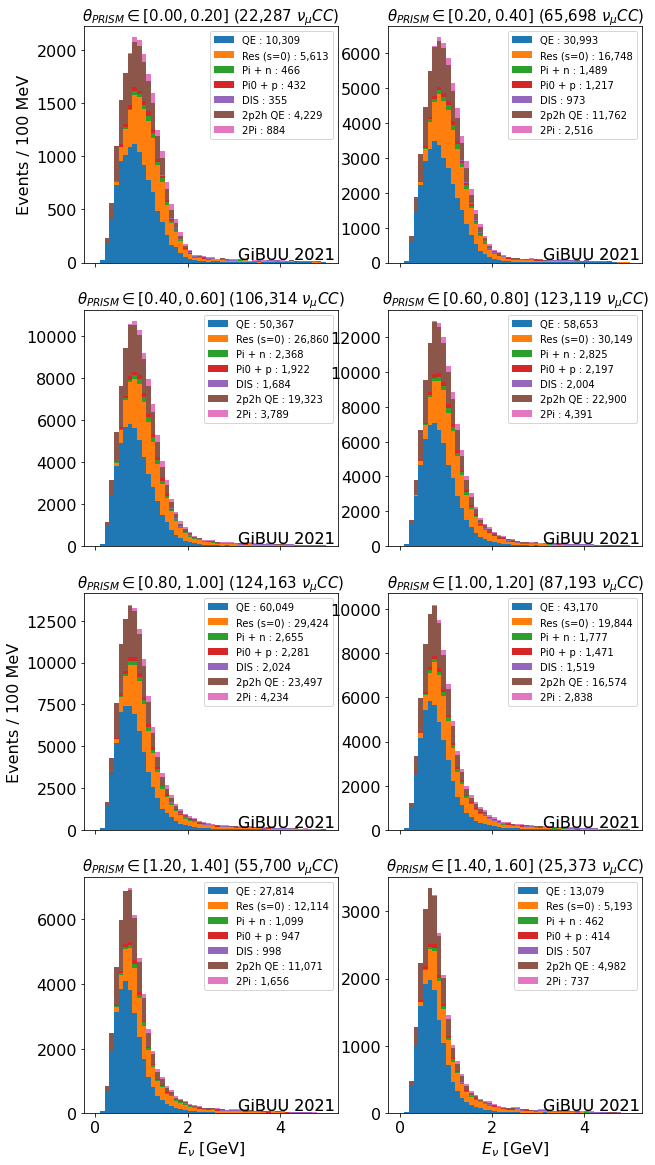

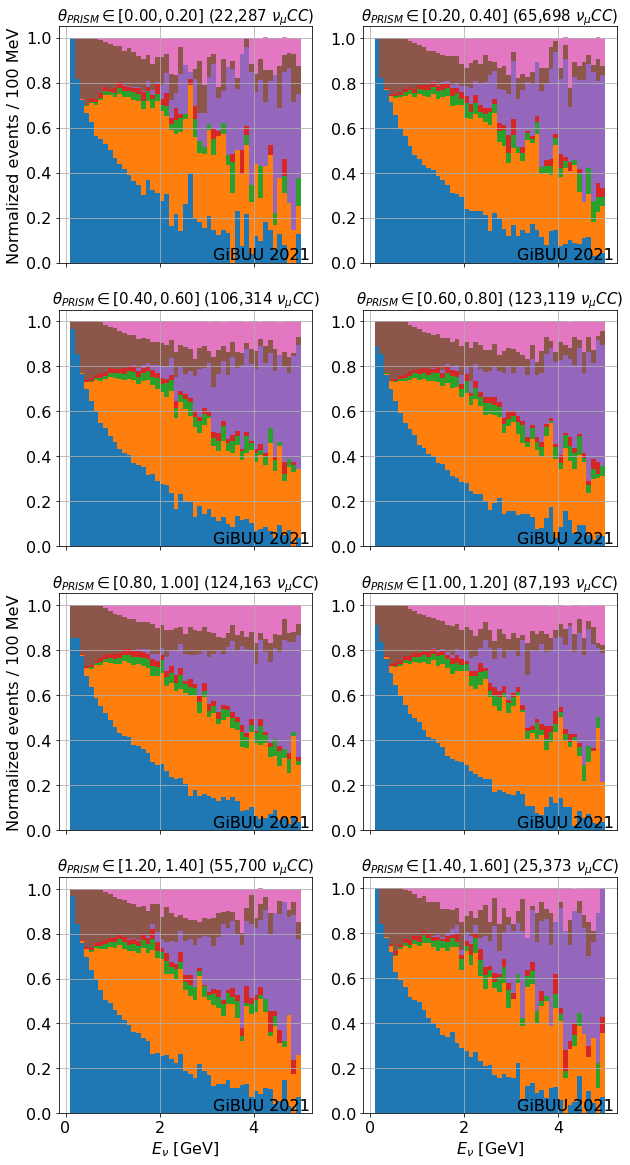

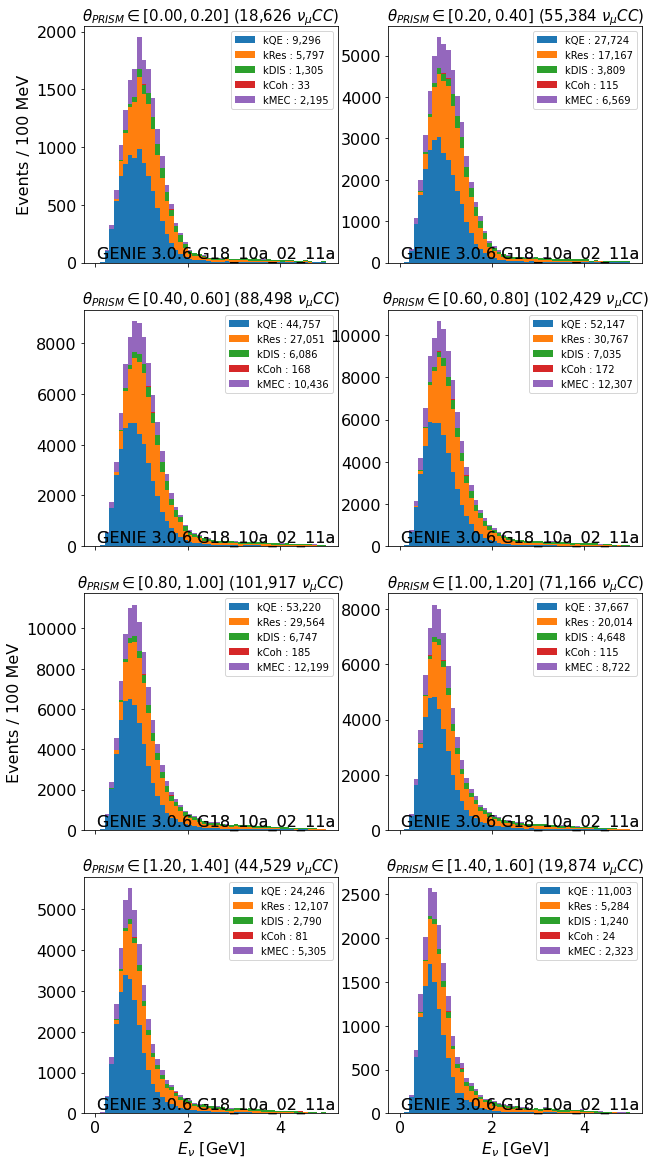

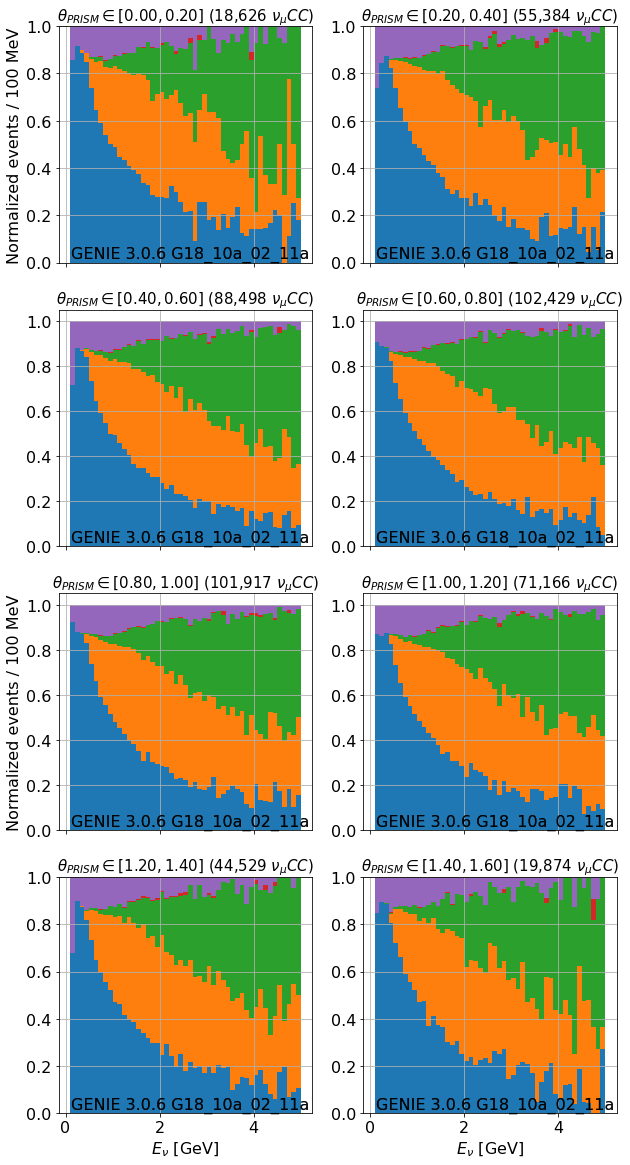

In [65]:
#Make these plots for different PRISM bins
fig_gibuu_all,axs_gibuu = plt.subplots(4,2,figsize=(10,20),sharex=True)
fig_gibuu_all_dens,axs_gibuu_dens = plt.subplots(4,2,figsize=(10,20),sharex=True)

fig_genie_all,axs_genie = plt.subplots(4,2,figsize=(10,20),sharex=True)
fig_genie_all_dens,axs_genie_dens = plt.subplots(4,2,figsize=(10,20),sharex=True)

for i,(ax_gibuu,ax_gibuu_dens,ax_genie,ax_genie_dens) in enumerate(zip(axs_gibuu.flatten(),axs_gibuu_dens.flatten(),axs_genie.flatten(),axs_genie_dens.flatten())):
  if PRISM_BINS[i] == PRISM_BINS[-1]: break #skip last bin to avoid range errors
  
  title = r'$\theta_{PRISM}' + rf' \in [{PRISM_BINS[i]:.2f},{PRISM_BINS[i+1]:.2f}]$'
  
  #Make plots
  for j,dens in enumerate(['','_dens']):
    if i %4 == 0: #is at the edge of a row
      ylabel='Normalized events' if j == 1 else 'Events'
    else:
      ylabel=None
    #GIBUU
    gibuu_df_inrange = gibuu_nu.data[gibuu_nu.data.prism_bins == i]
    make_mode_plots(gibuu_df_inrange,GIBUU_INTERACTION_MAP,weights=gibuu_df_inrange.genweight,
                            density=True if j == 1 else False, #set density
                            ylabel=ylabel,
                            title=title + f' ({round(gibuu_df_inrange.genweight.sum()):,}' + r' $\nu_\mu CC$)',
                            ax=ax_gibuu if j == 0 else ax_gibuu_dens,
                            fig=fig_gibuu_all if j == 0 else fig_gibuu_all_dens
                            )
    
    #GENIE
    genie_df_inrange = genie_nu.data[genie_nu.data.prism_bins == i]
    make_mode_plots(genie_df_inrange,GENIE_INTERACTION_MAP,weights=genie_df_inrange.genweight,
                            density=True if j == 1 else False, #set density
                            ylabel=ylabel,
                            title=title + f' ({round(genie_df_inrange.genweight.sum()):,}' + r' $\nu_\mu CC$)',
                            ax=ax_genie if j == 0 else ax_genie_dens,
                            fig=fig_genie_all if j == 0 else fig_genie_all_dens,
                            )
    for k,ax in enumerate([ax_genie,ax_genie_dens,ax_gibuu,ax_gibuu_dens]):
      if k == 0 or k == 2: #legend for non density plots
        ax.legend()
      if i < 6:
        ax.set_xlabel(None) #Turn off xlabel for upper plots
      if k == 0 or k == 1:
        label = GENIE_MODEL
      else:
        label = GIBUU_MODEL
      plotters.add_label(ax,label,where='bottomright',fontsize=16,alpha=0.8,color='black')
      plotters.set_style(ax,legend_size=10,title_size=15)
      
if save_plots:
  plotters.save_plot(f'gibuu_modes_prism_dens',fig=fig_gibuu_all_dens,folder_name=PLOTS_DIR) 
  plotters.save_plot(f'gibuu_modes_prism',fig=fig_gibuu_all,folder_name=PLOTS_DIR) 
  plotters.save_plot(f'genie_modes_prism_dens',fig=fig_genie_all_dens,folder_name=PLOTS_DIR) 
  plotters.save_plot(f'genie_modes_prism',fig=fig_genie_all,folder_name=PLOTS_DIR) 

## Muon info

In [4]:
#Muon phase space bins
# COSTHETA_BINS = np.array([-1,-0.5,0,0.27,0.45,0.62,0.76,0.86,0.94,1])
# THETA_BINS = np.arccos(COSTHETA_BINS)*180/np.pi

# MOMENTUM_BINS = np.array([0,0.3,0.5,0.7,0.9,1.1,1.3,1.5,2,3])

#Get muons
genie_muons = genie_prim.get_true_parts_from_pdg(13)
gibuu_muons = gibuu_prim.get_true_parts_from_pdg(13)

#Set modes
genie_muons.add_genmode(genie_nu)
gibuu_muons.add_genmode(gibuu_nu)

#Set weights
genie_muons.add_genweight(genie_nu)
gibuu_muons.add_genweight(gibuu_nu)

#Total number of muons
genie_muon_count = genie_muons.get_part_count()
gibuu_muon_count = gibuu_muons.get_part_count()

AttributeError: 'DataFrame' object has no attribute 'genweight'

In [6]:
#Total number of muons
genie_muon_count = genie_muons.get_part_count()
gibuu_muon_count = gibuu_muons.get_part_count()

In [9]:
#genie_muons.data.keys(),genie_nu.data.keys()

(MultiIndex([(         'plane',         'I0', 'I0', 'nhit'),
             (         'plane',         'I0', 'I1', 'nhit'),
             (         'plane',         'I0', 'I2', 'nhit'),
             (         'plane',         'I1', 'I0', 'nhit'),
             (         'plane',         'I1', 'I1', 'nhit'),
             (         'plane',         'I1', 'I2', 'nhit'),
             (         'plane',         'I0', 'I0', 'visE'),
             (         'plane',         'I0', 'I1', 'visE'),
             (         'plane',         'I0', 'I2', 'visE'),
             (         'plane',         'I1', 'I0', 'visE'),
             (         'plane',         'I1', 'I1', 'visE'),
             (         'plane',         'I1', 'I2', 'visE'),
             ( 'start_process',           '',   '',     ''),
             (   'end_process',           '',   '',     ''),
             (           'pdg',           '',   '',     ''),
             (        'startE',           '',   '',     ''),
             (         '

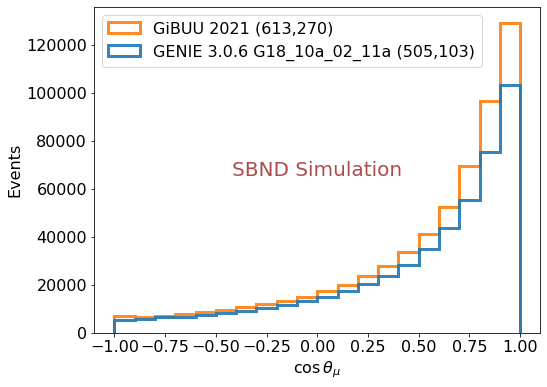

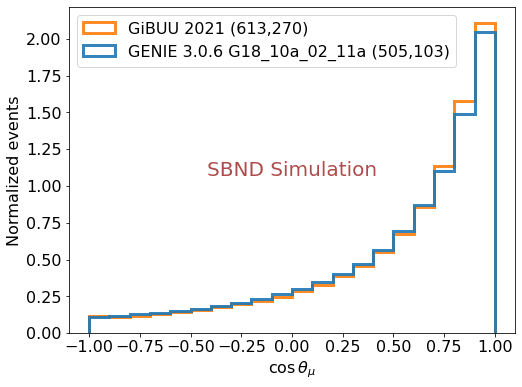

In [33]:
for i,dens in enumerate(['','_dens']):
    fig,ax = plt.subplots(figsize=(8,6))
    h = ax.hist([genie_muons.data.costheta,gibuu_muons.data.costheta],
        bins=np.arange(-1,1.1,0.1),
        weights=[genie_muons.data.genweight,gibuu_muons.data.genweight],
        histtype='step',
        lw=3,
        alpha=0.9,
        label=[f'{GENIE_MODEL} ({round(genie_muon_count):,})',
        f'{GIBUU_MODEL} ({round(gibuu_muon_count):,})',],
        density=True if i == 1 else False, #set density
        )
    ax.legend()
    ax.set_xlabel(r'$\cos\theta_\mu$')
    ax.set_ylabel('Normalized events' if i == 1 else 'Events')

    plotters.set_style(ax,legend_loc='upper left')
    plotters.add_label(ax,SIM_LABEL,alpha=0.7,fontsize=20,color='darkred',where='center')
    if save_plots:
        plotters.save_plot(f'costheta_mu{dens}',fig=fig,folder_name=PLOTS_DIR)

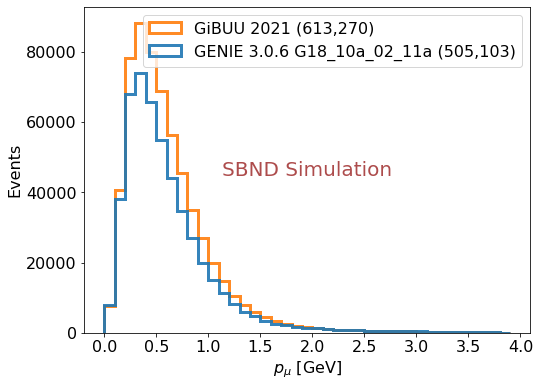

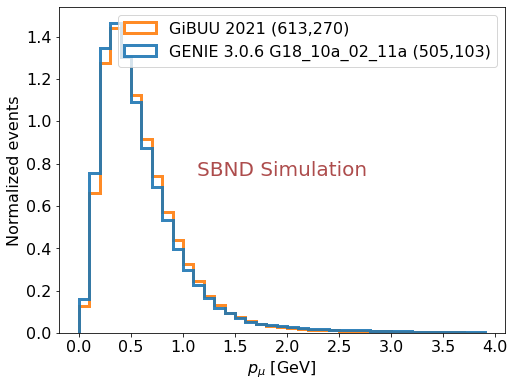

In [34]:
for i,dens in enumerate(['','_dens']):
    fig,ax = plt.subplots(figsize=(8,6))
    h = ax.hist([genie_muons.data.genp.tot,gibuu_muons.data.genp.tot,],
                bins=np.arange(0,4,0.1),
                weights=[genie_muons.data.genweight,gibuu_muons.data.genweight],
                histtype='step',
                lw=3,
                alpha=0.9,
                label=[f'{GENIE_MODEL} ({round(genie_muon_count):,})',
                f'{GIBUU_MODEL} ({round(gibuu_muon_count):,})',],
                density=True if i == 1 else False, #set density
        )
    ax.legend()
    ax.set_xlabel(r'$p_\mu$ [GeV]')
    ax.set_ylabel('Normalized events' if i == 1 else 'Events')

    plotters.set_style(ax,legend_loc='upper right')
    plotters.add_label(ax,SIM_LABEL,alpha=0.7,fontsize=20,color='darkred',where='center')
    if save_plots:
        plotters.save_plot(f'momentum_mu{dens}',fig=fig,folder_name=PLOTS_DIR)

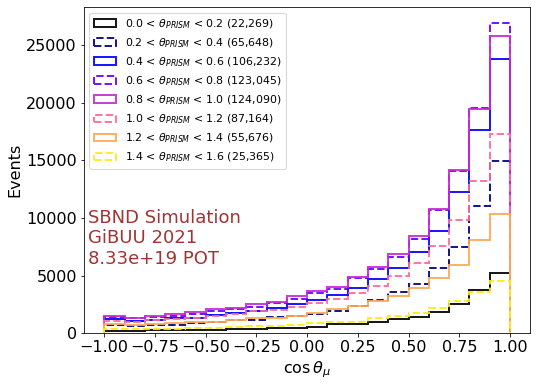

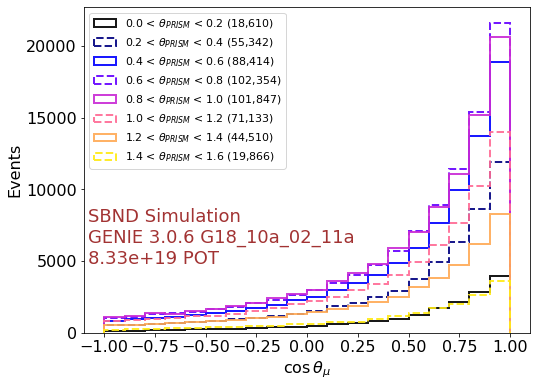

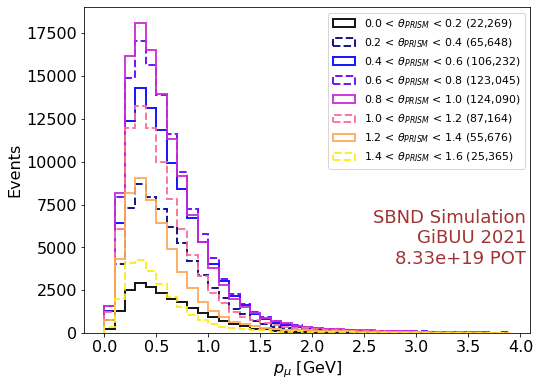

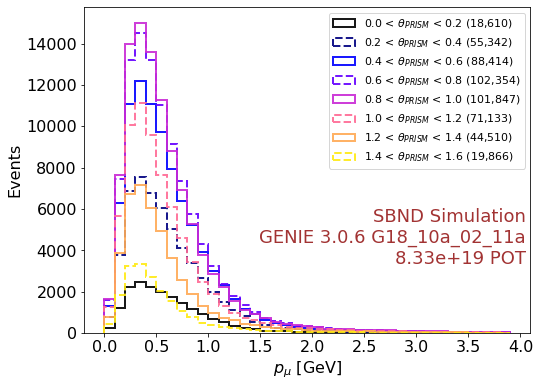

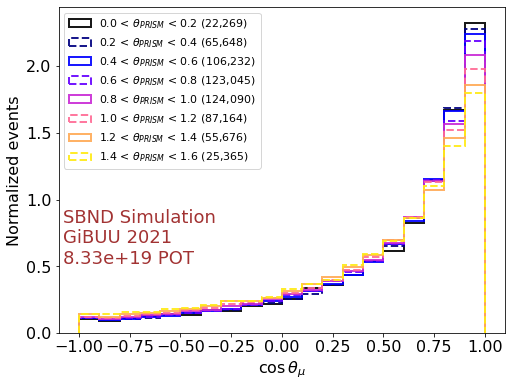

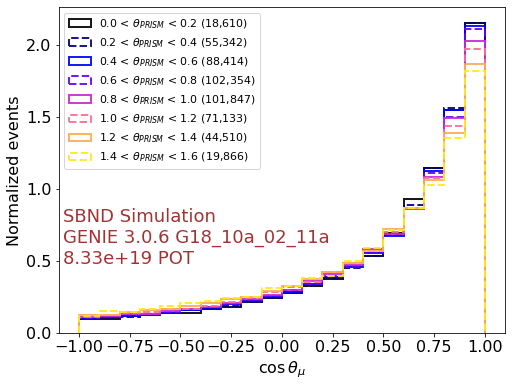

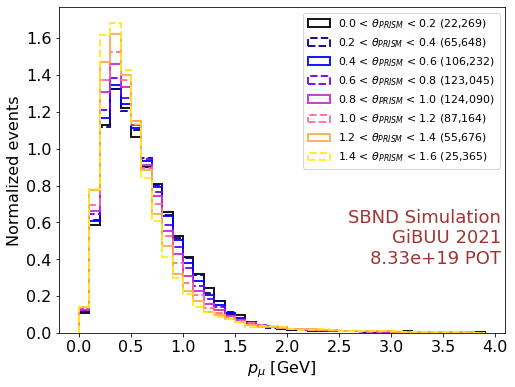

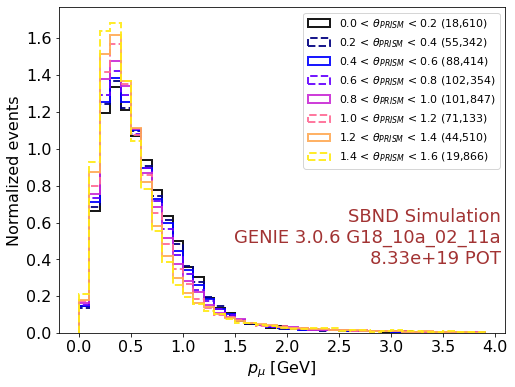

In [38]:
#Make list of colors from colormap the same length as thetas
colors = plotters.get_colors('gnuplot2',len(PRISM_BINS)-1)

#Prism plot for muon kinematics - let's do this all at once to avoid double counting errors
for i,dens in enumerate(['','_dens']):
    #Figures forr angles
    fig_gibuu_costheta,ax_gibuu_costheta = plt.subplots(figsize=(8,6))
    fig_genie_costheta,ax_genie_costheta = plt.subplots(figsize=(8,6))
    
    #Figures for momenta
    fig_gibuu_momentum,ax_gibuu_momentum = plt.subplots(figsize=(8,6))
    fig_genie_momentum,ax_genie_momentum = plt.subplots(figsize=(8,6))
    
    #Make a list for repeated tasks
    axs = [ax_gibuu_costheta,ax_genie_costheta,ax_gibuu_momentum,ax_genie_momentum]
    ax_thetas = [ax_gibuu_costheta,ax_genie_costheta]
    ax_momenta = [ax_gibuu_momentum,ax_genie_momentum]
    
    #Labels for figures
    labels_gibuu = [None]*(len(PRISM_BINS)-1)
    labels_genie = labels_gibuu.copy()
    
    for j,_ in enumerate(PRISM_BINS):
        if PRISM_BINS[j] == PRISM_BINS[-1]: break #skip last bin to avoid range errors
        #Mask prism bins
        genie_muons_inrange = genie_muons.data[genie_muons.data.prism_bins == j]
        gibuu_muons_inrange = gibuu_muons.data[gibuu_muons.data.prism_bins == j]
        
        #Set labels
        labels_genie[j] = f'{round(PRISM_BINS[j],2)} < ' + r'$\theta_{PRISM}$'\
        + f' < {round(PRISM_BINS[j+1],2)} ({round(np.sum(genie_muons_inrange.genweight)):,})'
        labels_gibuu[j] = f'{round(PRISM_BINS[j],2)} < ' + r'$\theta_{PRISM}$'\
        + f' < {round(PRISM_BINS[j+1],2)} ({round(np.sum(gibuu_muons_inrange.genweight)):,})'
        
        #Make histograms
        ax_gibuu_costheta.hist(gibuu_muons_inrange.costheta, #cos theta values
            bins=np.arange(-1,1.1,0.1),
            weights=gibuu_muons_inrange.genweight,
            histtype='step',
            lw=2,
            alpha=0.9,
            label=labels_gibuu[j],
            density=True if i == 1 else False, #set density
            linestyle='-' if j % 2 == 0 else '--', #alternate linestyle to help with visibility
            color=colors[j],
            )
        ax_gibuu_momentum.hist(gibuu_muons_inrange.genp.tot, #momentum values
            bins=np.arange(0,4,0.1),
            weights=gibuu_muons_inrange.genweight,
            histtype='step',
            lw=2,
            alpha=0.9,
            label=labels_gibuu[j],
            density=True if i == 1 else False, #set density
            color=colors[j],
            linestyle='-' if j % 2 == 0 else '--', #alternate linestyle to help with visibility
            )
        ax_genie_costheta.hist(genie_muons_inrange.costheta, #cos theta values
            bins=np.arange(-1,1.1,0.1),
            weights=genie_muons_inrange.genweight,
            histtype='step',
            lw=2,
            alpha=0.9,
            label=labels_genie[j],
            density=True if i == 1 else False, #set density
            color=colors[j],
            linestyle='-' if j % 2 == 0 else '--', #alternate linestyle to help with visibility
            )
        ax_genie_momentum.hist(genie_muons_inrange.genp.tot, #momentum values
            bins=np.arange(0,4,0.1),
            weights=genie_muons_inrange.genweight,
            histtype='step',
            lw=2,
            alpha=0.9,
            label=labels_genie[j],
            density=True if i == 1 else False, #set density
            color=colors[j],
            linestyle='-' if j % 2 == 0 else '--', #alternate linestyle to help with visibility
            )
    
    
    #Set xlabels
    ax_gibuu_costheta.set_xlabel(r'$\cos\theta_\mu$')
    ax_gibuu_momentum.set_xlabel(r'$p_\mu$ [GeV]')
    ax_genie_costheta.set_xlabel(r'$\cos\theta_\mu$')
    ax_genie_momentum.set_xlabel(r'$p_\mu$ [GeV]')
    
    #Set labels
    plotters.add_label(ax_gibuu_costheta,GIBUU_LABEL,alpha=0.8,fontsize=18,color='darkred',where='bottomishleft')
    plotters.add_label(ax_genie_costheta,GENIE_LABEL,alpha=0.8,fontsize=18,color='darkred',where='bottomishleft')
    plotters.add_label(ax_gibuu_momentum,GIBUU_LABEL,alpha=0.8,fontsize=18,color='darkred',where='bottomishright')
    plotters.add_label(ax_genie_momentum,GENIE_LABEL,alpha=0.8,fontsize=18,color='darkred',where='bottomishright')
    
    for k,ax in enumerate(axs):
        ax.set_ylabel('Normalized events' if i == 1 else 'Events')
        ax.legend()
    for k,ax in enumerate(ax_thetas):
        plotters.set_style(ax,legend_size=11,legend_loc='upper left')
    for k,ax in enumerate(ax_momenta):
        plotters.set_style(ax,legend_size=11,legend_loc='upper right')
    if save_plots:
        plotters.save_plot(f'genie_prism_muon_costheta{dens}',fig=fig_genie_costheta,folder_name=PLOTS_DIR)
        plotters.save_plot(f'gibuu_prism_muon_costheta{dens}',fig=fig_gibuu_costheta,folder_name=PLOTS_DIR)
        plotters.save_plot(f'genie_prism_muon_momentum{dens}',fig=fig_genie_momentum,folder_name=PLOTS_DIR)
        plotters.save_plot(f'gibuu_prism_muon_momentum{dens}',fig=fig_gibuu_momentum,folder_name=PLOTS_DIR)



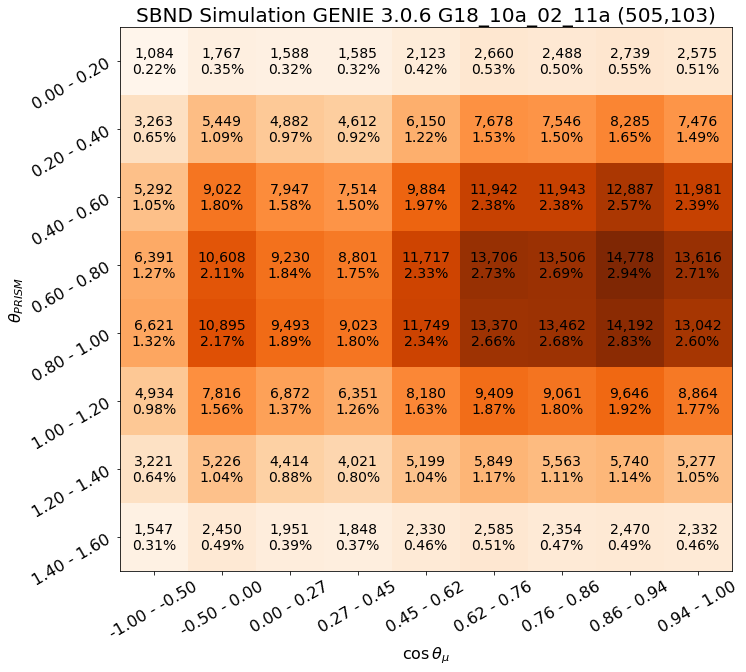

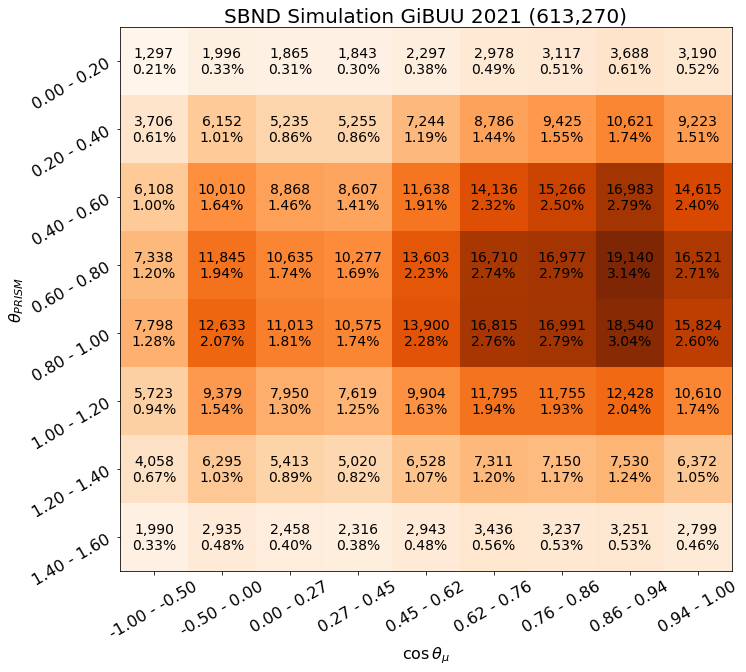

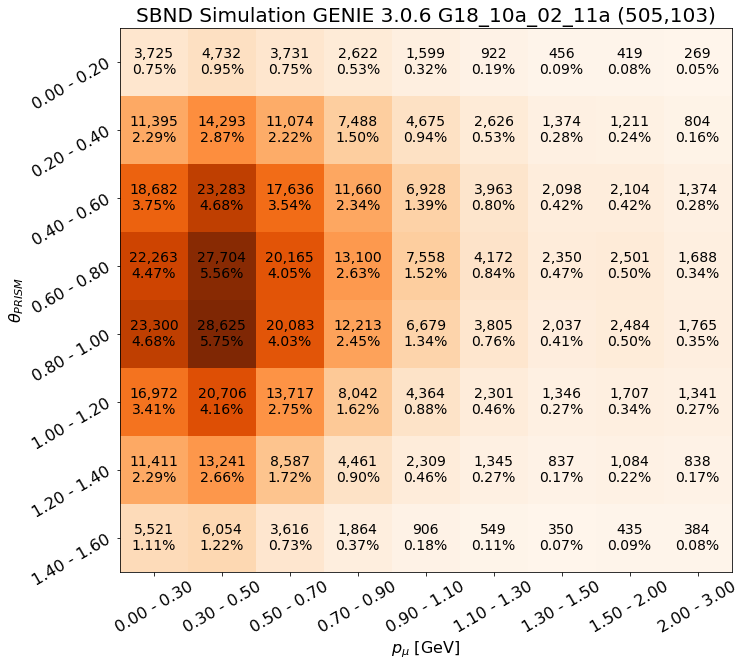

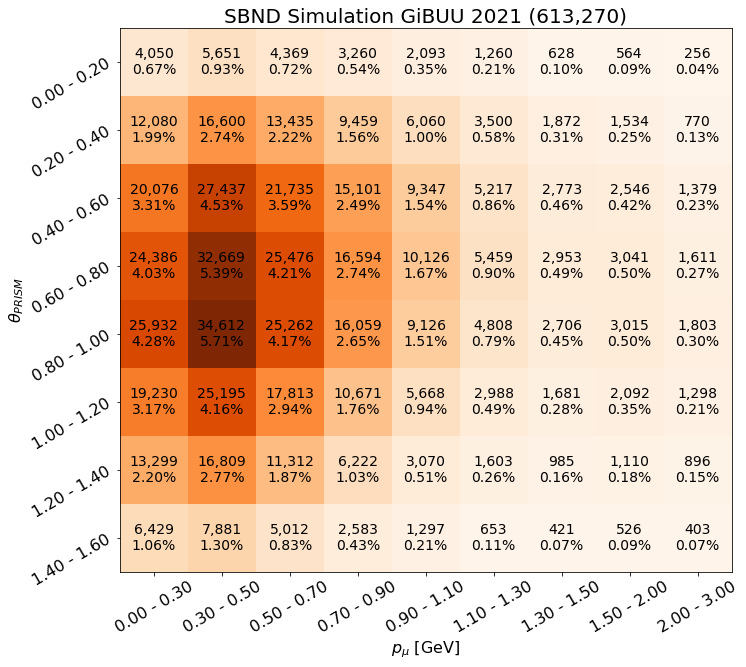

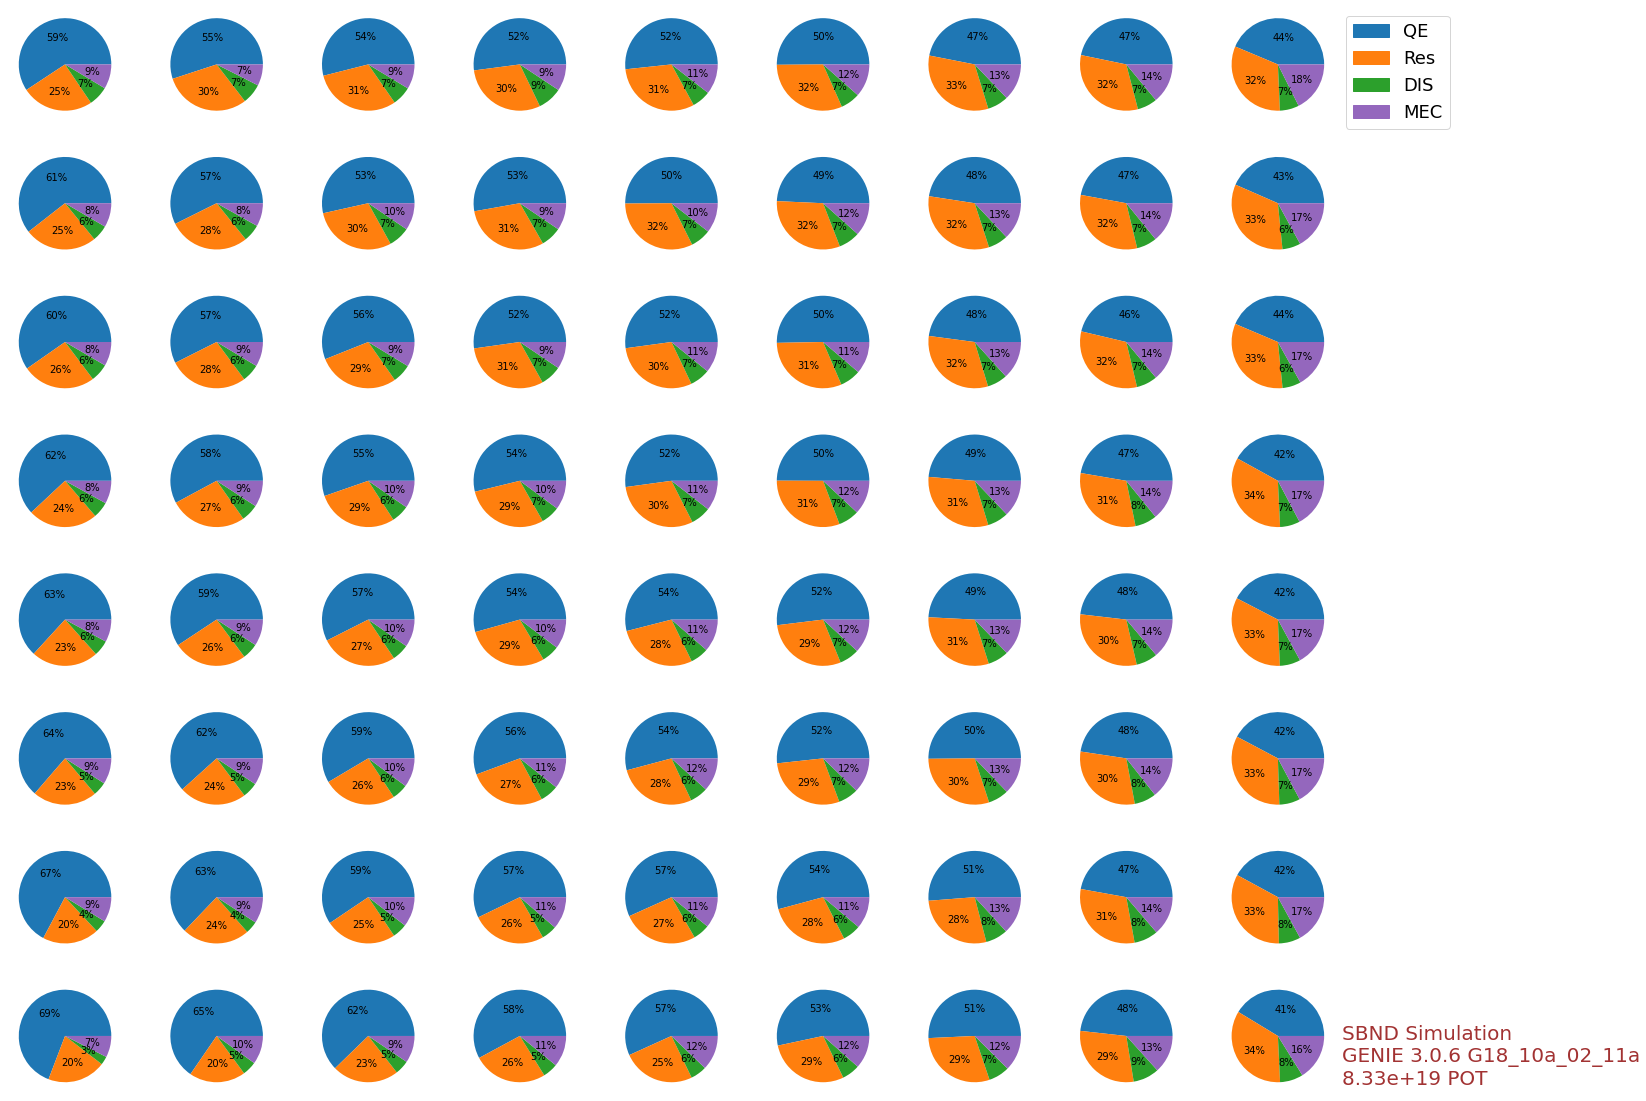

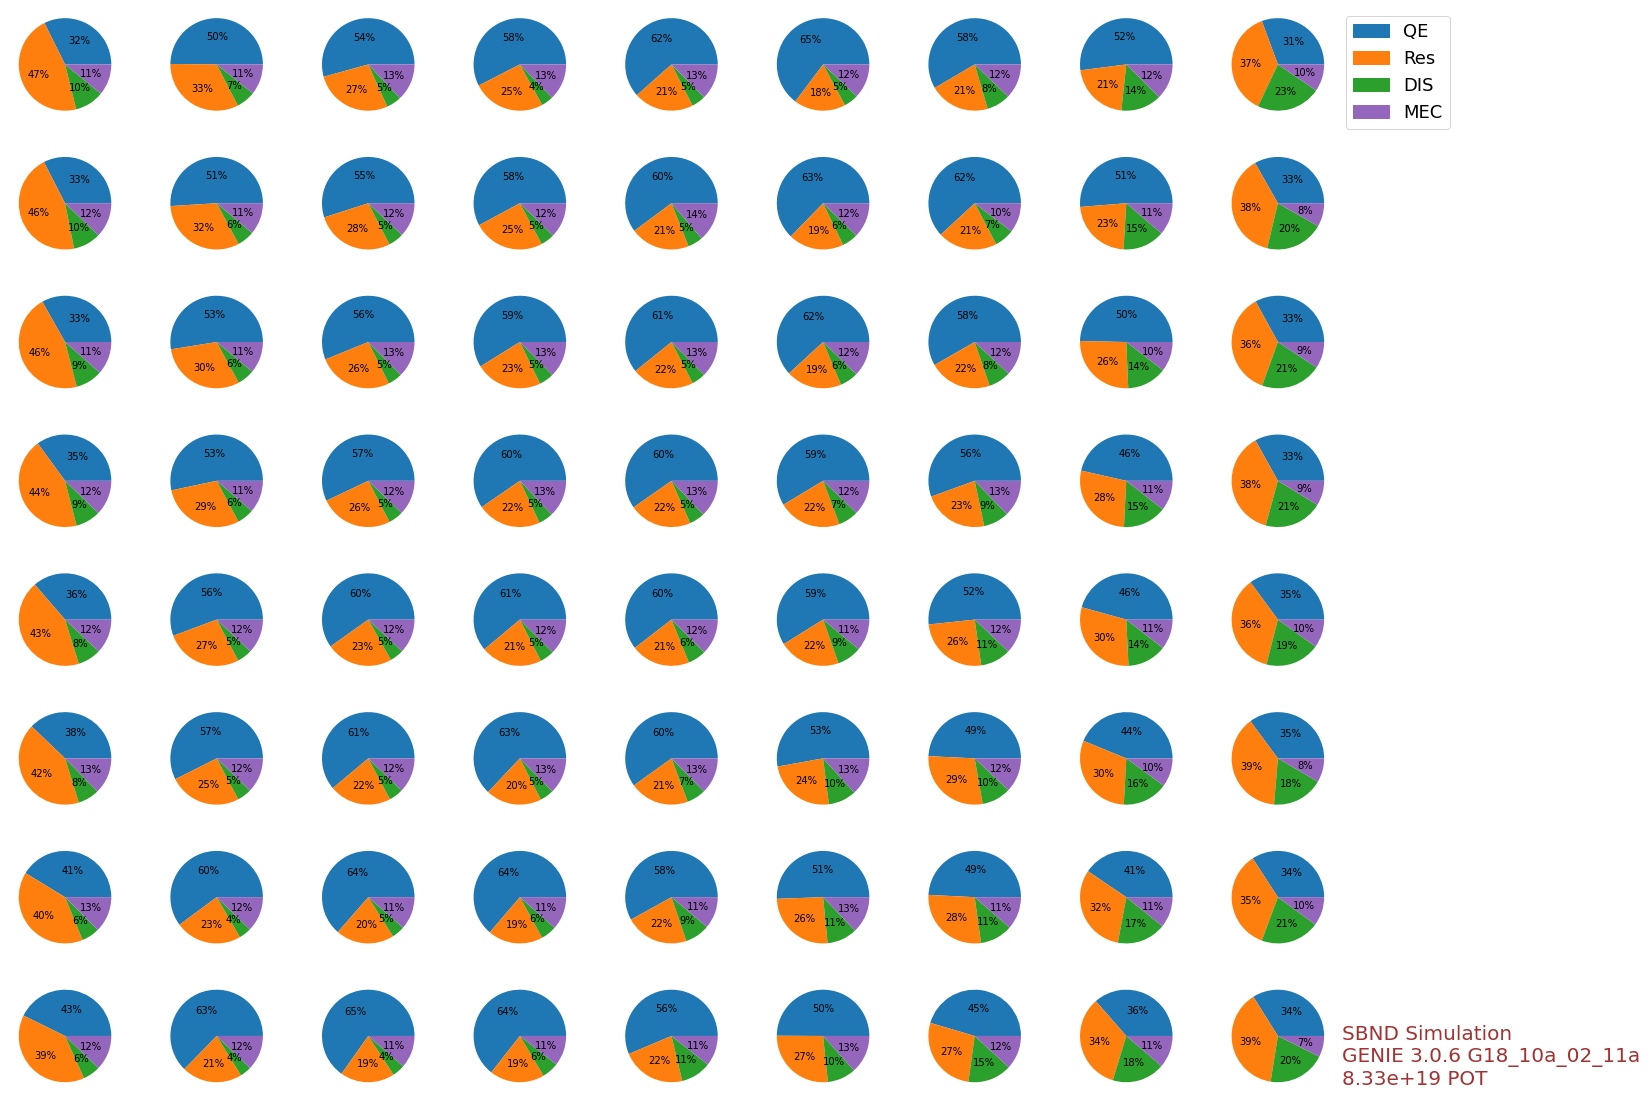

In [40]:
#fig and ax for 2d hists
fig_genie_angle,ax_genie_angle = plt.subplots(figsize=(12,10))
fig_gibuu_angle,ax_gibuu_angle = plt.subplots(figsize=(12,10))

fig_genie_momentum,ax_genie_momentum = plt.subplots(figsize=(12,10))
fig_gibuu_momentum,ax_gibuu_momentum = plt.subplots(figsize=(12,10))

#pie charts
fig_genie_angle_pie, axs_genie_angle_pie = plt.subplots(len(PRISM_BINS)-1, len(COSTHETA_BINS)-1, figsize=(24,20))
fig_genie_momentum_pie, axs_genie_momentum_pie = plt.subplots(len(PRISM_BINS)-1, len(MOMENTUM_BINS)-1, figsize=(24,20))

#Make legend labels for pie chart
colors_pie = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#9467bd']
labels_pie = ['QE','Res','DIS','MEC']
modes_genie = [0,1,2,10]
legend_elements = [Patch(facecolor=color, edgecolor=color, label=label) for label, color in zip(labels_pie, colors_pie)]

#Prism vs momentum
genie_angle_events = np.zeros((len(PRISM_BINS)-1,len(COSTHETA_BINS)-1))
gibuu_angle_events = genie_angle_events.copy()

#Theta vs momentum
genie_momentum_events = np.zeros((len(PRISM_BINS)-1,len(MOMENTUM_BINS)-1))
gibuu_momentum_events = genie_momentum_events.copy()

for i in range(len(PRISM_BINS)-1): #Prism theta bins
  #if i >0: break
  
  for j in range(len(THETA_BINS)-1): #Muon angle bins
    #Mask to prism and theta bins
    genie_muons_inrange = genie_muons.data[(genie_muons.data.prism_bins == i) &\
      (genie_muons.data.costheta_bins == j)]
    gibuu_muons_inrange = gibuu_muons.data[(gibuu_muons.data.prism_bins == i) &\
      (gibuu_muons.data.costheta_bins == j)]
    
    #Get weights
    genie_weights = genie_muons_inrange.genweight
    gibuu_weights = gibuu_muons_inrange.genweight
    
    #Get modes
    genie_modes = genie_muons_inrange.genie_mode
    gibuu_modes = gibuu_muons_inrange.genie_mode
    
    #Get number of events from weights
    genie_angle_events[i][j] = np.sum(genie_weights)
    gibuu_angle_events[i][j] = np.sum(gibuu_weights)
    
    #Pie chart with different modes
    genie_mode_ratios = [np.sum(genie_weights[genie_modes == mode]) for mode in modes_genie]
    axs_genie_angle_pie[i,j].pie(genie_mode_ratios,
                  colors=colors_pie,
                 #labels=GENIE_INTERACTION_MAP.values(), 
                 autopct='%1.0f%%'
                 )
    axs_genie_angle_pie[i,j].set_xticks([])
    axs_genie_angle_pie[i,j].set_yticks([])
  for j in range(len(MOMENTUM_BINS)-1): #Muon momentum bins
    #Mask to prism and theta bins
    genie_muons_inrange = genie_muons.data[(genie_muons.data.prism_bins == i) &\
      (genie_muons.data.momentum_bins == j)]
    gibuu_muons_inrange = gibuu_muons.data[(gibuu_muons.data.prism_bins == i) &\
      (gibuu_muons.data.momentum_bins == j)]
    
    #Get weights
    genie_weights = genie_muons_inrange.genweight
    gibuu_weights = gibuu_muons_inrange.genweight
    
    #Get modes
    genie_modes = genie_muons_inrange.genie_mode
    gibuu_modes = gibuu_muons_inrange.genie_mode
    
    #Get number of events from weights
    genie_momentum_events[i][j] = np.sum(genie_weights)
    gibuu_momentum_events[i][j] = np.sum(gibuu_weights)
    
    #Pie chart with different modes
    genie_mode_ratios = [np.sum(genie_weights[genie_modes == mode]) for mode in modes_genie]
    axs_genie_momentum_pie[i,j].pie(genie_mode_ratios,
                  colors=colors_pie,
                 #labels=GENIE_INTERACTION_MAP.values(), 
                 autopct='%1.0f%%'
                 )
    axs_genie_momentum_pie[i,j].set_xticks([])
    axs_genie_momentum_pie[i,j].set_yticks([])

#Prep tick labels
costheta_ticklabels = [f'{COSTHETA_BINS[i]:.2f} - {COSTHETA_BINS[i+1]:.2f}' for i in range(len(COSTHETA_BINS)-1)]
momentum_ticklabels = [f'{MOMENTUM_BINS[i]:.2f} - {MOMENTUM_BINS[i+1]:.2f}' for i in range(len(MOMENTUM_BINS)-1)]
prismtheta_ticklabels = [f'{PRISM_BINS[i]:.2f} - {PRISM_BINS[i+1]:.2f}' for i in range(len(PRISM_BINS)-1)]

#Genie - angle table
genie_im_angle = ax_genie_angle.imshow(genie_angle_events,cmap='Oranges')
for j in range(len(COSTHETA_BINS)-1):
    for i in range(len(PRISM_BINS)-1):
        text = ax_genie_angle.text(j,i, f'{round(genie_angle_events[i, j]):,}'+'\n'+f'{round(100*genie_angle_events[i, j]/np.sum(genie_angle_events),2):.2f}%', 
                             ha="center", va="center",fontsize=14)
ax_genie_angle.set_title(SIM_LABEL+' '+GENIE_MODEL+f' ({round(genie_muon_count):,})')

#Genie - momentum table
genie_im_momentum = ax_genie_momentum.imshow(genie_momentum_events,cmap='Oranges')
for j in range(len(MOMENTUM_BINS)-1):
    for i in range(len(PRISM_BINS)-1):
        text = ax_genie_momentum.text(j,i, f'{round(genie_momentum_events[i, j]):,}'+'\n'+f'{round(100*genie_momentum_events[i, j]/np.sum(genie_momentum_events),2):.2f}%', 
                             ha="center", va="center",fontsize=14)
ax_genie_momentum.set_title(SIM_LABEL+' '+GENIE_MODEL+f' ({round(genie_muon_count):,})')

#Gibuu - angle table
gibuu_im_angle = ax_gibuu_angle.imshow(gibuu_angle_events,cmap='Oranges')
for j in range(len(COSTHETA_BINS)-1):
    for i in range(len(PRISM_BINS)-1):
        text = ax_gibuu_angle.text(j, i, f'{round(gibuu_angle_events[i, j]):,}'+'\n'+f'{round(100*gibuu_angle_events[i, j]/np.sum(gibuu_angle_events),2):.2f}%', 
                             ha="center", va="center",fontsize=14)
ax_gibuu_angle.set_title(SIM_LABEL+' '+GIBUU_MODEL+f' ({round(gibuu_muon_count):,})')

#Gibuu - momentum table
gibuu_im_momentum = ax_gibuu_momentum.imshow(gibuu_momentum_events,cmap='Oranges')
for j in range(len(MOMENTUM_BINS)-1):
    for i in range(len(PRISM_BINS)-1):
        text = ax_gibuu_momentum.text(j,i, f'{round(gibuu_momentum_events[i, j]):,}'+'\n'+f'{round(100*gibuu_momentum_events[i, j]/np.sum(gibuu_momentum_events),2):.2f}%', 
                             ha="center", va="center",fontsize=14)
ax_gibuu_momentum.set_title(SIM_LABEL+' '+GIBUU_MODEL+f' ({round(gibuu_muon_count):,})')

#Both angle plots
for ax in [ax_genie_angle,ax_gibuu_angle]:
  ax.set_xlabel(r'$\cos\theta_\mu$')
  ax.set_xticks(np.arange(0,len(COSTHETA_BINS)-1))
  ax.set_xticklabels(labels=costheta_ticklabels,rotation=30)
#Both momentum plots
for ax in [ax_genie_momentum,ax_gibuu_momentum]:
  ax.set_xlabel(r'$p_\mu$ [GeV]')
  ax.set_xticks(np.arange(0,len(MOMENTUM_BINS)-1))
  ax.set_xticklabels(labels=momentum_ticklabels,rotation=30)
#All imshow plots
for ax in [ax_genie_angle,ax_gibuu_angle,ax_genie_momentum,ax_gibuu_momentum]:
  ax.set_ylabel(r'$\theta_{PRISM}$')
  ax.set_yticks(np.arange(0,len(PRISM_BINS)-1))
  ax.set_yticklabels(labels=prismtheta_ticklabels,rotation=30)
  plotters.set_style(ax)

#Pie plots
for axs in [axs_genie_angle_pie,axs_genie_momentum_pie]:
  axs[0,-1].legend(handles=legend_elements,fontsize=18,bbox_to_anchor=(1.01,1))
  plotters.add_label(axs[-1,-1],GENIE_LABEL,where='bottomrightoutside',fontsize=20,alpha=0.8,color='darkred')

if True:
    plotters.save_plot('genie_prism_muon_costheta_counts',fig=fig_genie_angle,folder_name=PLOTS_DIR)
    plotters.save_plot('gibuu_prism_muon_costheta_counts',fig=fig_gibuu_angle,folder_name=PLOTS_DIR)
    
    plotters.save_plot('genie_prism_muon_momentum_counts',fig=fig_genie_momentum,folder_name=PLOTS_DIR)
    plotters.save_plot('gibuu_prism_muon_momentum_counts',fig=fig_gibuu_momentum,folder_name=PLOTS_DIR)
    
    plotters.save_plot('genie_prism_muon_costheta_pie',fig=fig_genie_angle_pie,folder_name=PLOTS_DIR)
    plotters.save_plot('genie_prism_muon_momentum_pie',fig=fig_genie_momentum_pie,folder_name=PLOTS_DIR)


In [ ]:
3 == 4

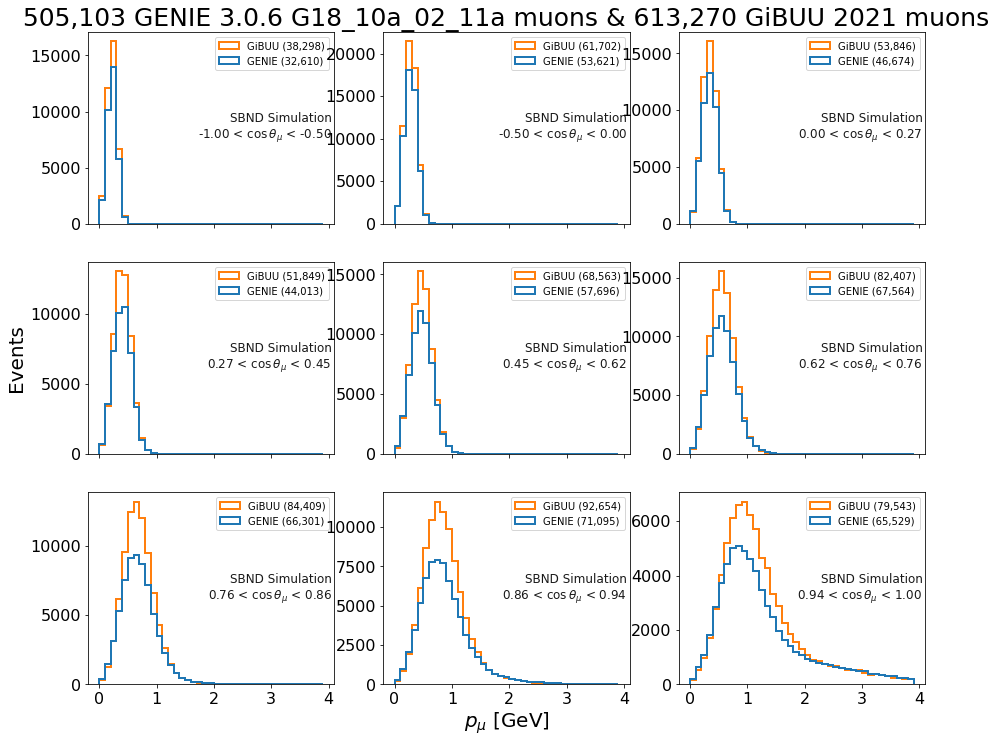

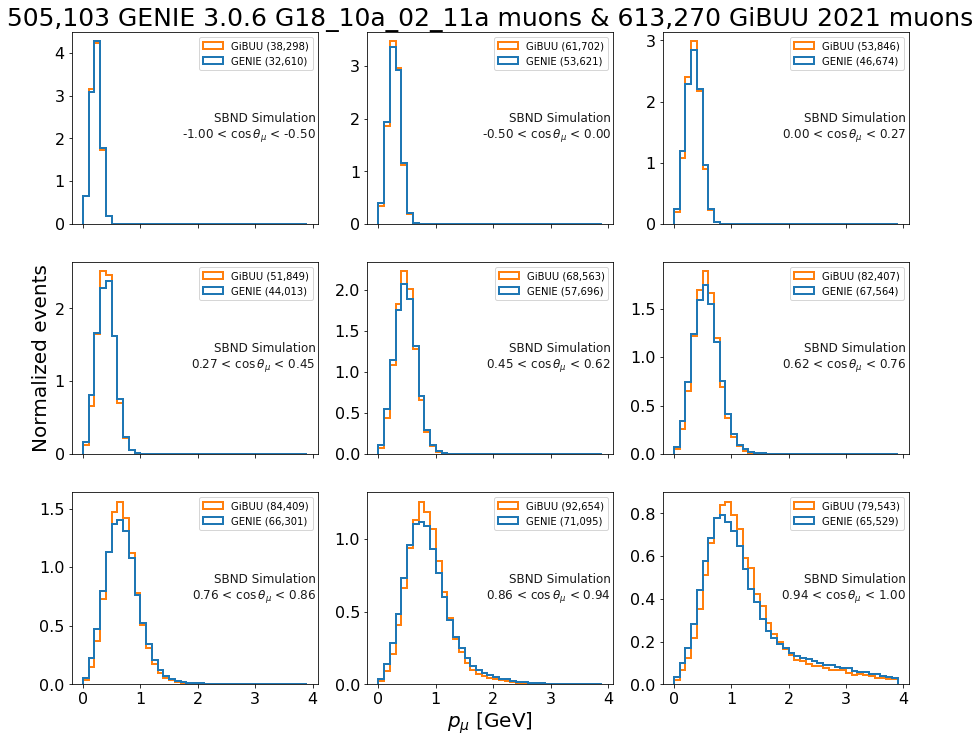

In [41]:
for j,dens in enumerate(['','_dens']):
  fig,axs = plt.subplots(nrows=3,ncols=3,figsize=(15,12),sharex=True)
  for i,ax in enumerate(axs.flatten()):
    #Get muons within theta bins
    genie_muons_inrange = genie_muons.data[(genie_muons.data.costheta_bins == i)]
    gibuu_muons_inrange = gibuu_muons.data[(gibuu_muons.data.costheta_bins == i)]
    
    #Get momenta
    ps_genie = genie_muons_inrange.genp.tot
    ps_gibuu = gibuu_muons_inrange.genp.tot
    
    #Get weights
    weights_genie = genie_muons_inrange.genweight
    weights_gibuu = gibuu_muons_inrange.genweight
    
    #Get number of events from weights
    genie_inrange_count = np.sum(weights_genie)
    gibuu_inrange_count = np.sum(weights_gibuu)
    
    ax.hist([ps_genie,ps_gibuu],
            bins=np.arange(0,4,0.1),
            weights=[weights_genie,weights_gibuu],
            histtype='step',
            lw=2,
            label=[f'GENIE ({round(genie_inrange_count):,})',
                  f'GiBUU ({round(gibuu_inrange_count):,})',],
            density=True if j == 1 else False)
    
    plotters.set_style(ax)
    plotters.add_label(ax,f'{SIM_LABEL}\n{COSTHETA_BINS[i]:.2f} < $\cos\\theta_\mu$ < {COSTHETA_BINS[i+1]:.2f}',fontsize=12,alpha=0.9,where='centerright')
    ax.legend()
  axs[2,1].set_xlabel(r'$p_\mu$ [GeV]',fontsize=20)
  axs[0,1].set_title(rf'{round(genie_muon_count):,} {GENIE_MODEL} muons & {round(gibuu_muon_count):,} {GIBUU_MODEL} muons',fontsize=25)
  axs[1,0].set_ylabel('Normalized events' if j == 1 else 'Events',fontsize=20)
  if save_plots:
    plotters.save_plot(f'momentum_mu_theta{dens}',fig=fig,folder_name=PLOTS_DIR)

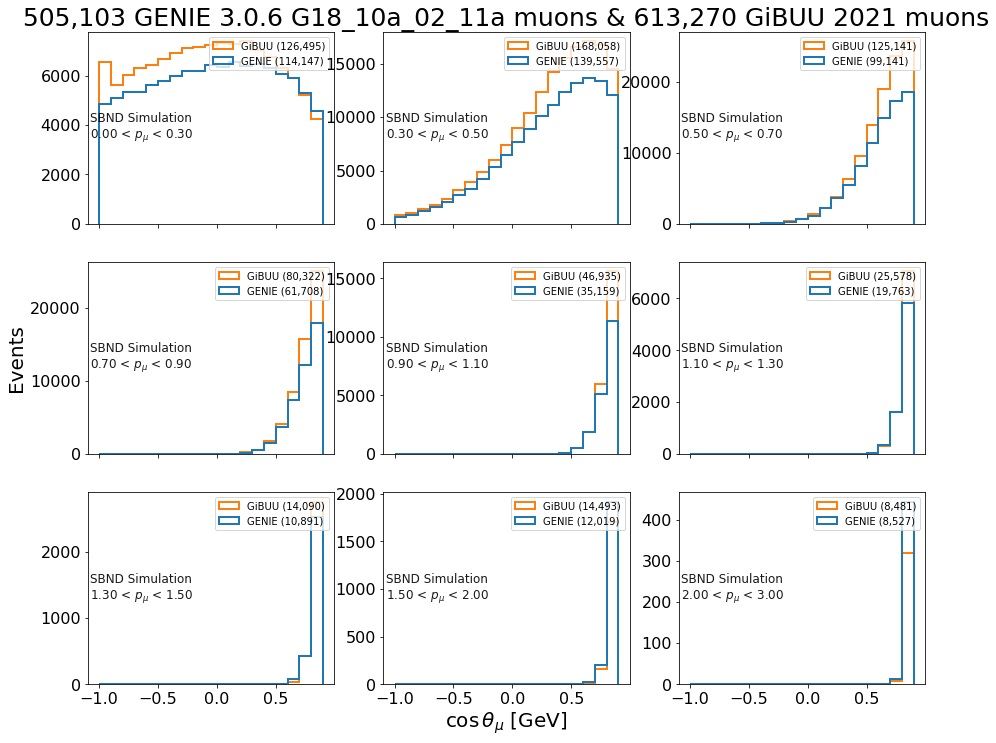

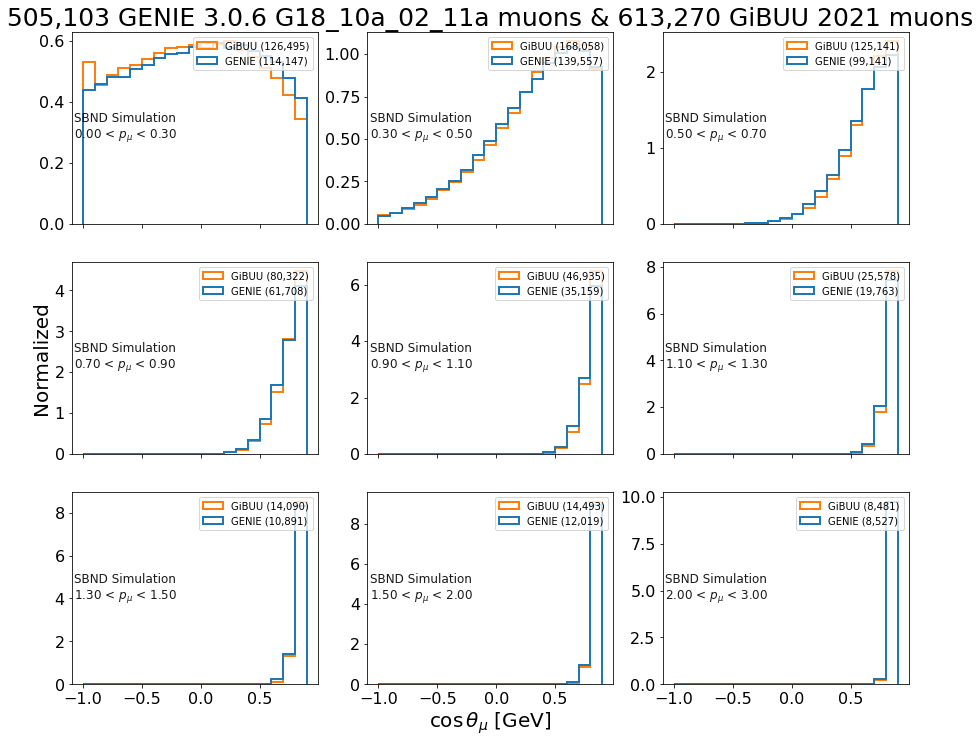

In [42]:
for j,dens in enumerate(['','_dens']):
  fig,axs = plt.subplots(nrows=3,ncols=3,figsize=(15,12),sharex=True)
  for i,ax in enumerate(axs.flatten()):
    #Make dataframes
    genie_muons_inrange = genie_muons.data[(genie_muons.data.momentum_bins == i)]
    gibuu_muons_inrange = gibuu_muons.data[(gibuu_muons.data.momentum_bins == i)]
    
    #Get angles
    costhetas_genie = genie_muons_inrange.costheta
    costhetas_gibuu = gibuu_muons_inrange.costheta
    
    #Get weights
    weights_genie = genie_muons_inrange.genweight
    weights_gibuu = gibuu_muons_inrange.genweight
    
    #Get number of events from weights
    genie_inrange_count = np.sum(weights_genie)
    gibuu_inrange_count = np.sum(weights_gibuu)
    
    ax.hist([costhetas_genie,costhetas_gibuu],
            bins=np.arange(-1,1,0.1),
            weights=[weights_genie,weights_gibuu],
            histtype='step',
            lw=2,
            label=[f'GENIE ({round(genie_inrange_count):,})',
                  f'GiBUU ({round(gibuu_inrange_count):,})',],
            density=True if j == 1 else False)
    
    plotters.set_style(ax)
    plotters.add_label(ax,f'{SIM_LABEL}\n{MOMENTUM_BINS[i]:.2f} < $p_\mu$ < {MOMENTUM_BINS[i+1]:.2f}',fontsize=12,alpha=0.9,where='centerleft')
    ax.legend()
  axs[2,1].set_xlabel(r'$\cos \theta_\mu$ [GeV]',fontsize=20)
  axs[0,1].set_title(rf'{round(genie_muon_count):,} {GENIE_MODEL} muons & {round(gibuu_muon_count):,} {GIBUU_MODEL} muons',fontsize=25)
  axs[1,0].set_ylabel('Normalized' if j == 1 else 'Events',fontsize=20)
  if save_plots:
    plotters.save_plot(f'theta_mu_momentum{dens}',fig=fig,folder_name=PLOTS_DIR)

0 11220 536600
0 10295 495470


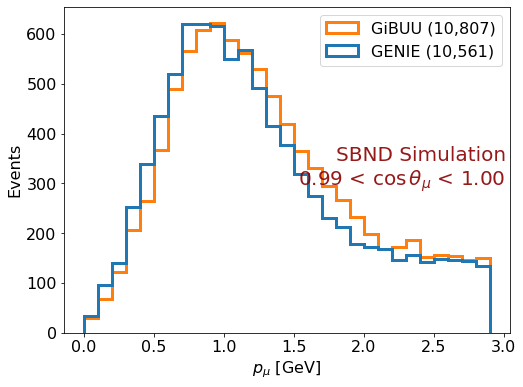

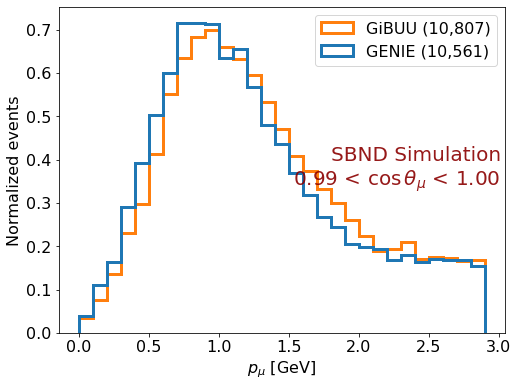

In [55]:
#Single cos range statistics
theta_lower = 0.99
theta_upper = 1

theta_bins = [theta_lower,theta_upper]

#Get muons within theta bins
genie_muons_inrange = genie_muons.copy()
gibuu_muons_inrange = gibuu_muons.copy()

#Mask to bin range
genie_muons_inrange.assign_costheta_bins(theta_bins)
gibuu_muons_inrange.assign_costheta_bins(theta_bins)

genie_muons_inrange_df = genie_muons_inrange.data[(genie_muons_inrange.data.costheta_bins == 0)]
gibuu_muons_inrange_df = gibuu_muons_inrange.data[(gibuu_muons_inrange.data.costheta_bins == 0)]

for j,dens in enumerate(['','_dens']):
  fig,ax = plt.subplots(figsize=(8,6))
  #Get weights
  weights_genie = genie_muons_inrange_df.genweight
  weights_gibuu = gibuu_muons_inrange_df.genweight
  
  #Get number of events from weights
  genie_inrange_count = np.sum(weights_genie)
  gibuu_inrange_count = np.sum(weights_gibuu)
  
  #Get momenta
  ps_genie = genie_muons_inrange_df.genp.tot
  ps_gibuu = gibuu_muons_inrange_df.genp.tot
  
  ax.hist([ps_genie,ps_gibuu],
          bins=np.arange(0,4,0.1),
          weights=[weights_genie,weights_gibuu],
          histtype='step',
          lw=3,
          label=[f'GENIE ({round(genie_inrange_count):,})',
                f'GiBUU ({round(gibuu_inrange_count):,})',],
          density=True if j == 1 else False)
  
  ax.legend()
  ax.set_xlabel(r'$p_\mu$ [GeV]',fontsize=20)
  ax.set_ylabel('Normalized events' if j == 1 else 'Events',fontsize=20)
  plotters.set_style(ax)
  plotters.add_label(ax,f'{SIM_LABEL}\n{theta_lower:.2f} < $\cos\\theta_\mu$ < {theta_upper:.2f}',
                     fontsize=20,alpha=0.9,where='centerright',color='darkred')
  if save_plots:
    plotters.save_plot(f'momentum_mu_single_theta_bin_lowerer{dens}',fig=fig,folder_name=PLOTS_DIR)

In [53]:
min(genie_muons_inrange_df.costheta)

0.9900005251539746

In [50]:
genie_nu.theta*180/np.pi,thetas

(__ntuple  entry  rec.mc.nu..index
 14        0      0                   0.645803
           2      1                   0.394984
           3      0                   0.457076
           4      1                   1.306399
           6      0                   1.036493
                                        ...   
 9999      117    1                   1.197030
           119    0                   0.355669
           125    1                   1.421708
           127    0                   1.256431
           128    1                   0.556889
 Name: theta, Length: 536969, dtype: float64,
 array([0. , 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.8]))

## Testing area

0
1
2
3
4
5
6
7


ValueError: too many values to unpack (expected 2)

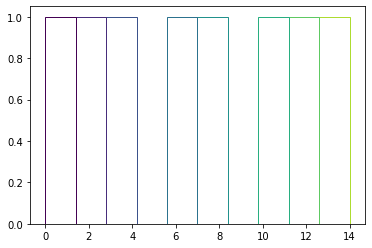

In [87]:
#Make list of colors from colormap the same length as thetas 
colors = plotters.get_colors('viridis',len(thetas)-1) 
xs = [None]*len(colors)
ys = xs.copy()
lss = xs.copy()
for ind in range(len(thetas)-1):   
  print(ind)   
  lss[ind] = 'solid' if ind%2 == 0 else 'dashed'
  ys[ind] = [2*ind]
plt.hist(ys,histtype='step',color=colors,label=lss,linestyle=tuple(lss)) 
plt.legend()

In [ ]:
prim_temp = MCPRIM(gibuu_prim.copy())
nu_temp   = NU(gibuu_nu.copy()) 

prim_temp.keys()

MultiIndex([(         'plane', 'I0', 'I0', 'nhit'),
            (         'plane', 'I0', 'I1', 'nhit'),
            (         'plane', 'I0', 'I2', 'nhit'),
            (         'plane', 'I1', 'I0', 'nhit'),
            (         'plane', 'I1', 'I1', 'nhit'),
            (         'plane', 'I1', 'I2', 'nhit'),
            (         'plane', 'I0', 'I0', 'visE'),
            (         'plane', 'I0', 'I1', 'visE'),
            (         'plane', 'I0', 'I2', 'visE'),
            (         'plane', 'I1', 'I0', 'visE'),
            (         'plane', 'I1', 'I1', 'visE'),
            (         'plane', 'I1', 'I2', 'visE'),
            ( 'start_process',   '',   '',     ''),
            (   'end_process',   '',   '',     ''),
            (           'pdg',   '',   '',     ''),
            (        'startE',   '',   '',     ''),
            (         'start',  'x',   '',     ''),
            (         'start',  'y',   '',     ''),
            (         'start',  'z',   '',     ''),
            

In [ ]:
for row,nu in gibuu_nu.head(2).iterrows():
  gibuu_prim.loc[idx[row[0],row[1],row[2],:],'nu.dir.x'] = nu.nu_dir.x
  gibuu_prim.loc[idx[row[0],row[1],row[2],:],'nu.dir.y'] = nu.nu_dir.y
  gibuu_prim.loc[idx[row[0],row[1],row[2],:],'nu.dir.z'] = nu.nu_dir.z
gibuu_prim

plane                \
                                                          I0                 
                                                          I0     I1     I2   
                                                        nhit   nhit   nhit   
__ntuple entry rec.mc.nu..index rec.mc.nu.prim..index                        
7        1     1                0                      543.0  438.0  815.0   
         2     0                0                      836.0  203.0  724.0   
                                1                        8.0    6.0    8.0   
         3     1                0                       85.0  245.0  293.0   
                                1                        2.0    4.0    3.0   
...                                                      ...    ...    ...   
20       46846 1                1                       11.0    7.0    7.0   
                                2                        3.0    3.0    3.0   
                                3                        3.0    3.0    3.0   
         46847 0                0                      308.0  160.0  192.0   
                                1                       44.0    8.0   45.0   

                                                                      \
                                                        I1             
                                                        I0   I1   I2   
                                                      nhit nhit nhit   
__ntuple entry rec.mc.nu..index rec.mc.nu.prim..index                  
7        1     1                0                        0    0    0   
         2     0                0                        0    0    0   
                                1                        0    0    0   
         3     1                0                        0    0    0   
                                1                        0    0    0   
...                                                    ...  ...  ...   
20       46846 1                1                        0    0    0   
                                2                        0    0    0   
                                3                        0    0    0   
         46847 0                0                        0    0    0   
                                1                        0    0    0   

                                                                           \
                                                             I0             
                                                             I0        I1   
                                                           visE      visE   
__ntuple entry rec.mc.nu..index rec.mc.nu.prim..index                       
7        1     1                0                      0.461822  0.461823   
         2     0                0                      0.471250  0.471251   
                                1                      0.047808  0.047808   
         3     1                0                      0.225677  0.225677   
                                1                      0.026855  0.026854   
...                                                         ...       ...   
20       46846 1                1                      0.088538  0.088538   
                                2                      0.014702  0.014702   
                                3                      0.016057  0.016057   
         46847 0                0                      0.185551  0.185551   
                                1                      0.139427  0.139427   

                                                                      ...  \
                                                                  I1  ...   
                                                             I2   I0  ...   
                                                           visE visE  ...   
__ntuple entry rec.mc.nu..index rec.mc.nu.prim..index                 ...   
7        1     1                0  

In [ ]:
# Make sure the columns you are merging on are not part of the index
gibuu_nu_reset = gibuu_nu.reset_index()
gibuu_prim_reset = gibuu_prim.reset_index()

# Rename columns in gibuu_nu_reset to match the target columns in gibuu_prim_reset
gibuu_nu_reset = gibuu_nu_reset.rename(columns={'nu_dir.x': 'nu.dir.x', 'nu_dir.y': 'nu.dir.y', 'nu_dir.z': 'nu.dir.z'})

gibuu_nu_reset

# Merge the dataframes on the index columns
result = pd.merge(gibuu_prim_reset, gibuu_nu_reset[['__ntuple', 'entry', 'rec.mc.nu..index', 'nu.dir.x', 'nu.dir.y', 'nu.dir.z']], 
                  on=['__ntuple', 'entry', 'rec.mc.nu..index'], 
                  how='left')

# # Set the index again to make it a MultiIndex DataFrame
result.set_index(['__ntuple', 'entry', 'rec.mc.nu..index', 'rec.mc.nu.prim..index'], inplace=True)

KeyError: "['nu.dir.x' 'nu.dir.y' 'nu.dir.z'] not in index"

In [ ]:
# Make sure the columns you are merging on are not part of the index
gibuu_nu_reset = gibuu_nu.reset_index()

# Rename columns in gibuu_nu_reset to match the target columns in gibuu_prim
gibuu_nu_reset = gibuu_nu_reset.rename(columns={'nu_dir.x': 'nu.dir.x', 'nu_dir.y': 'nu.dir.y', 'nu_dir.z': 'nu.dir.z'})

# Set the index again to make it a MultiIndex DataFrame
#gibuu_nu_reset.set_index(['__ntuple', 'entry', 'rec.mc.nu..index', 'rec.mc.nu.prim..index'], inplace=True)

# Use update method to update corresponding values
gibuu_prim.update(gibuu_nu_reset)

In [ ]:
gibuu_prim

plane                \
                                                          I0                 
                                                          I0     I1     I2   
                                                        nhit   nhit   nhit   
__ntuple entry rec.mc.nu..index rec.mc.nu.prim..index                        
7        1     1                0                      543.0  438.0  815.0   
         2     0                0                      836.0  203.0  724.0   
                                1                        8.0    6.0    8.0   
         3     1                0                       85.0  245.0  293.0   
                                1                        2.0    4.0    3.0   
...                                                      ...    ...    ...   
20       46846 1                1                       11.0    7.0    7.0   
                                2                        3.0    3.0    3.0   
                                3                        3.0    3.0    3.0   
         46847 0                0                      308.0  160.0  192.0   
                                1                       44.0    8.0   45.0   

                                                                      \
                                                        I1             
                                                        I0   I1   I2   
                                                      nhit nhit nhit   
__ntuple entry rec.mc.nu..index rec.mc.nu.prim..index                  
7        1     1                0                        0    0    0   
         2     0                0                        0    0    0   
                                1                        0    0    0   
         3     1                0                        0    0    0   
                                1                        0    0    0   
...                                                    ...  ...  ...   
20       46846 1                1                        0    0    0   
                                2                        0    0    0   
                                3                        0    0    0   
         46847 0                0                        0    0    0   
                                1                        0    0    0   

                                                                           \
                                                             I0             
                                                             I0        I1   
                                                           visE      visE   
__ntuple entry rec.mc.nu..index rec.mc.nu.prim..index                       
7        1     1                0                      0.461822  0.461823   
         2     0                0                      0.471250  0.471251   
                                1                      0.047808  0.047808   
         3     1                0                      0.225677  0.225677   
                                1                      0.026855  0.026854   
...                                                         ...       ...   
20       46846 1                1                      0.088538  0.088538   
                                2                      0.014702  0.014702   
                                3                      0.016057  0.016057   
         46847 0                0                      0.185551  0.185551   
                                1                      0.139427  0.139427   

                                                                      ...  \
                                                                  I1  ...   
                                                             I2   I0  ...   
                                                           visE visE  ...   
__ntuple entry rec.mc.nu..index rec.mc.nu.prim..index                 ...   
7        1     1                0  

In [ ]:
df = pd.read_hdf('/sbnd/data/users/brindenc/analyze_sbnd/numu/MCP2022A/test.df',key='mcnu')

In [ ]:
s0 = time()
#Find the indices using a mask
av_mask = involume(genie_nu.position)
numu_mask = (np.abs(genie_nu.pdg) == 14)
cc_mask = (genie_nu.iscc == 0)

#Find the intersection of all three
mask = av_mask.values & numu_mask.values & cc_mask.values
s1 = time()
s1-s0

0.008027791976928711

In [ ]:
s0 = time()
av_inds = genie_nu.position.query('x <= 200 and x >= -200 and y <= 200 and y >= -200 and z <= 500 and z >= 0').index
numu_inds = genie_nu[np.abs(genie_nu.pdg) == 14].index
cc_inds = genie_nu[genie_nu.iscc == 0].index

#Find intersection of all three
inds = numu_inds.intersection(cc_inds.intersection(av_inds))
#len(inds),len(av_inds),len(numu_inds),len(cc_inds),len(genie_nu)
s1 = time()
s1-s0

0.03000187873840332

## Testing loading file

In [ ]:
tree = uproot.open('/pnfs/sbnd/persistent/users/laliaga/GiBUU_SBND/AnaFiles/flatcafs/GiBUU_r000_flat.caf.root')
test_tree = uproot.open('/sbnd/app/users/brindenc/mysbnana_v09_75_03/srcs/sbnana/sbnana/SBNAna/pyana/test/test.flat.root')
tree.keys(),test_tree.keys()

(['env;1',
  'env/envtree;1',
  'recTree;1',
  'TotalPOT;1',
  'TotalEvents;1',
  'metadata;1',
  'metadata/metatree;1'],
 ['env;1',
  'env/envtree;2',
  'env/envtree;1',
  'TotalPOT;1',
  'TotalEvents;1',
  'recTree;1',
  'metadata;1',
  'metadata/metatree;1'])

In [ ]:

file = open('cafkeys.txt','w')
file.write('\n'.join(tree['recTree;1'].keys()) + '\n')
file.close()
#df = tree['recTree;1'].arrays(['rec.mc.nu.prim.gstatus'],library='pd')

In [ ]:
np.unique(df.values)

array([-1], dtype=int16)

In [ ]:
len(tree['recTree;1'].keys()),len([k for k in tree['recTree;1'].keys() if 'rec.' in k])

(1545, 1545)

In [ ]:
[k for k in test_tree['recTree;1'].keys() if 'idx' in k]

['rec.fake_reco.hadrons..idx',
 'rec.hdr.bnbinfo.M875BB..idx',
 'rec.hdr.bnbinfo.M876BB..idx',
 'rec.hdr.bnbinfo.MMBTBB..idx',
 'rec.hdr.numiinfo.HITGT..idx',
 'rec.hdr.numiinfo.HP121..idx',
 'rec.hdr.numiinfo.HPTGT..idx',
 'rec.hdr.numiinfo.MTGTDS..idx',
 'rec.hdr.numiinfo.VITGT..idx',
 'rec.hdr.numiinfo.VP121..idx',
 'rec.hdr.numiinfo.VPTGT..idx',
 'rec.mc.nu.genVersion..idx',
 'rec.mc.nu.prim.daughters..idx',
 'rec.mc.nu.prim..idx',
 'rec.mc.nu.wgt.univ..idx',
 'rec.mc.nu.wgt..idx',
 'rec.reco.pfp.daughters..idx',
 'rec.reco.pfp.shw.selVars.showerResiduals..idx',
 'rec.reco.pfp.shw.truth.matches..idx',
 'rec.reco.pfp.shw.truth.p.daughters..idx',
 'rec.reco.pfp.trk.calo.0.points..idx',
 'rec.reco.pfp.trk.calo.1.points..idx',
 'rec.reco.pfp.trk.calo.2.points..idx',
 'rec.reco.pfp.trk.truth.matches..idx',
 'rec.reco.pfp.trk.truth.p.daughters..idx',
 'rec.reco.stub.planes.hits..idx',
 'rec.reco.stub.planes..idx',
 'rec.reco.stub.truth.matches..idx',
 'rec.reco.stub.truth.p.daughters..id

In [ ]:
len(utils.find_indices_in_common(mcnubranches,tree['recTree;1'].keys())),len(mcnubranches)

(7, 7)

In [ ]:
len(utils.find_indices_in_common(mcprimbranches,tree['recTree;1'].keys())),len(mcprimbranches)

(30, 30)

In [ ]:
len(utils.find_indices_in_common(hdrbranches,tree['recTree;1'].keys())),len(hdrbranches)

(8, 8)

In [ ]:
hdrbranches

['rec.hdr.pot',
 'rec.hdr.first_in_subrun',
 'rec.hdr.run',
 'rec.hdr.subrun',
 'rec.hdr.ngenevt',
 'rec.hdr.evt',
 'rec.hdr.proc',
 'rec.hdr.cluster']